<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q yfinance

     |████████████████████████████████| 63 kB 467 kB/s 
     |████████████████████████████████| 6.4 MB 3.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader

import yfinance as yf

import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

import numpy as np 

from datetime import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN', 'DELL']

#Import from API
end = dt.now()
start = dt(end.year - 4, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

number_of_days = end - start
us_bd = np.busdaycalendar
datelist_past = pd.date_range(start, end, freq='C').tolist()    

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN, DELL]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "DELL"]

for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

#Additional Columns
for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:3]
#cols.pop(1) #Delete middle column

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape == (1008, 9)
Featured selected: ['Open', 'High', 'Low']


In [4]:
DELL.head()

,Open,High,Low,Close,Adj Close,Volume,company_name,openChange,closeChange
Date,,,,,,,,,
2018-05-04,19.889214,20.641338,19.807825,20.472952,20.330540,2996327,DELL,NaN,NaN
2018-05-07,20.486984,20.795692,20.293341,20.343857,20.202341,2057770,DELL,0.030055,-0.006306
2018-05-08,20.352276,20.352276,19.936922,20.209146,20.068569,5340225,DELL,-0.006575,-0.006622
2018-05-09,20.284922,20.669401,20.225985,20.408403,20.266439,5428237,DELL,-0.003309,0.009860
2018-05-10,20.461725,21.163336,20.447695,20.961271,20.815462,4681738,DELL,0.008716,0.027090


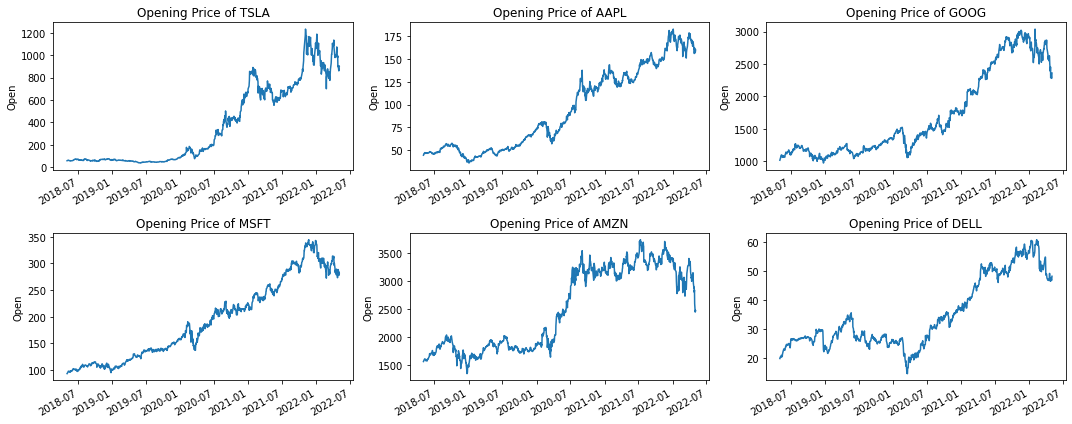

In [5]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

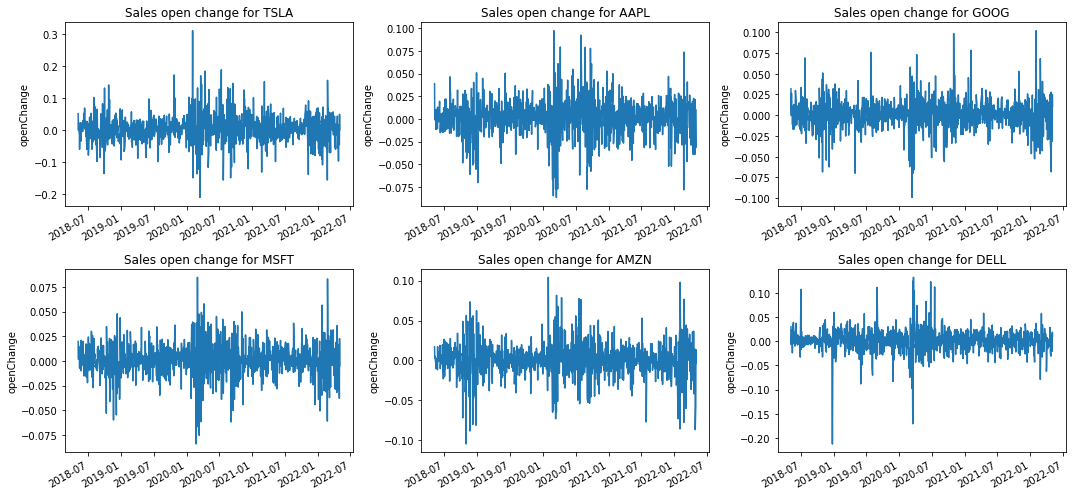

In [6]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

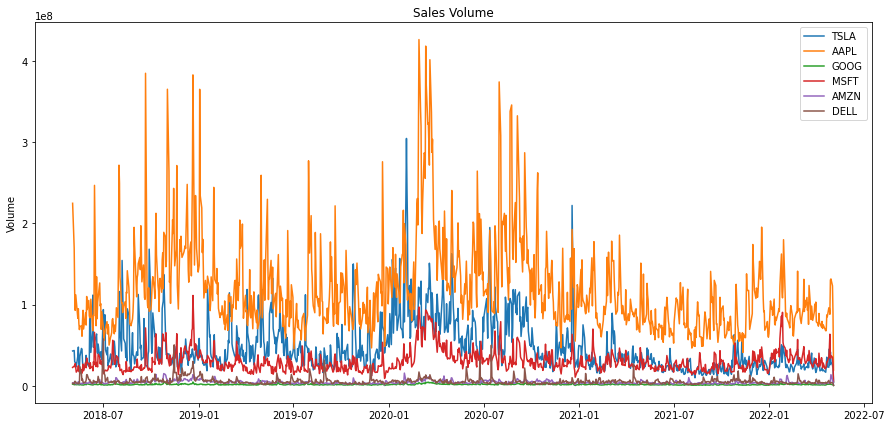

In [7]:
mplot.figure(figsize=(15, 7))
mplot.title(f"Sales Volume")
for i, stock in enumerate(stocks, 1):
  mplot.plot(stock['Volume'], label = stockTypes[i - 1]) 
  
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show()  

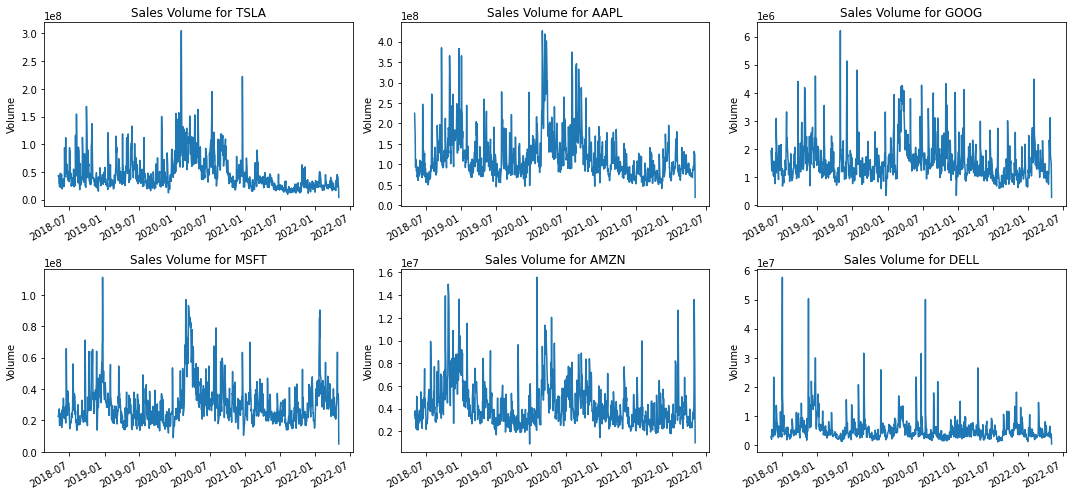

In [8]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [9]:
#Get Desired columns to train
stockDf = stocks[0]
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 300
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open', 'High', 'Low']
Shape of training set == (250, 3).


,Open,High,Low
Date,,,
2018-07-18,65.000000,65.099998,63.250000
2018-07-19,63.265999,64.708000,62.801998
2018-07-20,64.246002,64.648003,62.341999
2018-07-23,60.368000,61.099998,58.571999


In [10]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [11]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [12]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
104/104 [==============================] - 10s 26ms/step - loss: 0.1212 - val_loss: 0.0299
Epoch 2/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0210 - val_loss: 0.0316
Epoch 3/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0181 - val_loss: 0.0318
Epoch 4/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0173 - val_loss: 0.0322
Epoch 5/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0175 - val_loss: 0.0315
Epoch 6/100
104/104 [==============================] - 1s 9ms/step - loss: 0.0174 - val_loss: 0.0321
Epoch 7/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0173 - val_loss: 0.0324
Epoch 8/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0169 - val_loss: 0.0321
Epoch 9/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0165 - val_loss: 0.0306
Epoch 10/100
104/104 [==============================] - 1s 10ms/step - loss: 0.0144 -

In [13]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]

Y_test = Y_test.reshape(s2,s1)
Y_train = Y_train.reshape(s2,s1)

In [14]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 519
X_test: 519
Y_train: 519
Y_test: 519
X Train Shape(519, 1, 5)
Y Train Shape(519, 1)
X Test Shape(519, 1, 5)
Y Test Shape(519, 1)
train_predict: 519
Y_trained_predict: 519
test_predict: 519
Y_test_predict: 519
Shape of Y_train:519
Shape of Y_train:519
Shape of Y_train:519
Shape of Y_train:519


In [15]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
1.7002951372750752 

Test RMSE is: 
5.215728474053329


In [16]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,65.100000,63.734131
1,63.250000,61.929298
2,63.265998,62.421379
3,64.707999,63.095360
4,62.801999,61.668739


Text(0, 0.5, 'Value of Stock')

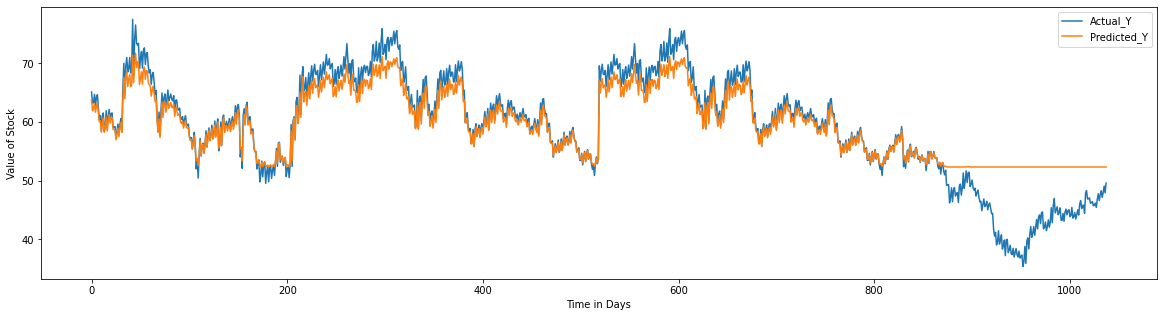

In [17]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [18]:

from pandas.tseries.offsets import BDay
BDay(4)

trainingStartDate = end - BDay(14)
print(trainingStartDate.to_pydatetime().date())

2022-04-14


In [22]:
from pandas.tseries.offsets import BDay

#Prediction Forcastings
predictionCount = 9
lookback =155 
yesterday = end - timedelta(days=1)
trainingStartDate = (end - BDay(lookback)).to_pydatetime()
forcastingTrainingDays = yesterday - trainingStartDate
datelist_future = pd.date_range(end, periods=predictionCount, freq='C').tolist()  
datelist_training = pd.date_range(trainingStartDate, yesterday, freq='C').tolist()

predictMeData = stockDf[-lookback:] 
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')
predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs) 

y_past_training = model.predict(X_train[-lookback-1:])
print(len(y_past_training))
y_past_training_values = scaler.inverse_transform(y_past_training[0:lookback])
print('y_past_training_values with X_train: ')
print(y_past_training_values[-5:])

y_future_prediction = model.predict(X_train[-predictionCount:])
y_future_prediction_values = scaler.inverse_transform(y_future_prediction)
print('y_future_prediction_values with X_train: ')
y_future_prediction_values1=scaler.inverse_transform(y_future_prediction_values)

print(y_future_prediction_values[:5])
print(len(y_past_training_values))
print(len(datelist_training))

#Look Back prediction
PREDICTIONS_FUTURE = pd.DataFrame(y_future_prediction_values, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_training_values, columns=['Open']).set_index(pd.Series(datelist_training)) 
PREDICTIONS_FUTURE.head(11)

156
y_past_training_values with X_train: 
[[926.2233 ]
 [920.1772 ]
 [925.25824]
 [938.49084]
 [928.2404 ]]
y_future_prediction_values with X_train: 
[[946.7791 ]
 [929.06036]
 [924.34766]
 [926.2233 ]
 [920.1772 ]]
155
155


,Open
2022-05-04 14:20:41.236518,946.779114
2022-05-05 14:20:41.236518,929.060364
2022-05-06 14:20:41.236518,924.347656
2022-05-09 14:20:41.236518,926.223328
2022-05-10 14:20:41.236518,920.177185
2022-05-11 14:20:41.236518,925.258240
2022-05-12 14:20:41.236518,938.490845
2022-05-13 14:20:41.236518,928.240417
2022-05-16 14:20:41.236518,938.155457


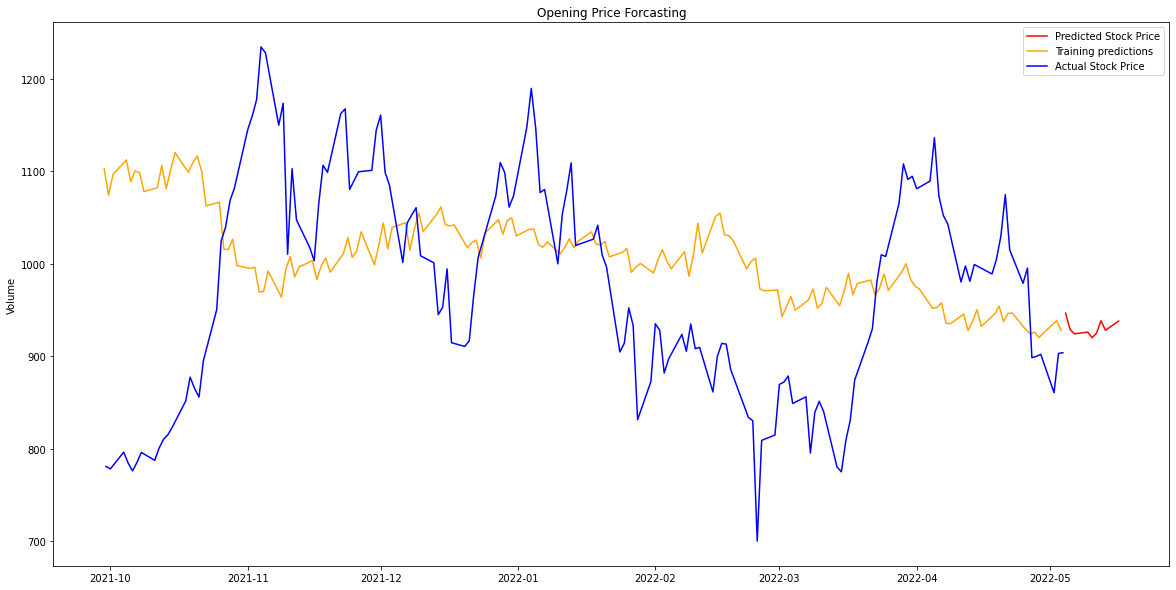

In [23]:
mplot.figure(figsize=(20,10))
mplot.title(f"Opening Price Forcasting")
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[trainingStartDate:].index, PREDICTION_TRAIN.loc[trainingStartDate:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[trainingStartDate:].index, stockDf.loc[trainingStartDate:]['Open'], color='b', label='Actual Stock Price')
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show() 